In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from helper import *
from scipy.stats.mstats import gmean
#Importation of all the packages
from datetime import datetime
import math
import json
import zipfile  
import ssl
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics

#To dowload data
import requests
import io
import gzip

#To create the mapchart
import iso3166
import plotly
from iso3166 import countries
import plotly.graph_objects as go
import plotly.express as px

/Users/arthurnussbaumer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Download pageviews
pageview_df = pd.read_csv("page_views_covid_related.csv.gz")
pageview_df_imp_country = pageview_df[["date"] + list(get_country_dict('original').values())].set_index('date')
pageview_df_imp_country.head()
country_dict = get_country_dict('original')
inv_country_dict = {v: k for k, v in country_dict.items()}

In [3]:
# Download covid data
ssl._create_default_https_context = ssl._create_unverified_context
death_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_deaths.csv?raw=true" # Make sure the url is the raw version of the file on GitHub
cases_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_cases.csv?raw=true"

# Reading the downloaded content and turning it into a pandas dataframe
deaths = pd.read_csv(death_url,index_col=0)
cases = pd.read_csv(cases_url,index_col=0)
deaths= deaths.interpolate(method ='linear', limit_direction ='forward') 
cases = cases.interpolate(method ='linear', limit_direction ='forward') 
deaths = deaths.fillna(0)
cases = cases.fillna(0)
#Keep only values until July
deaths = deaths[deaths.index < '2022-01-01']
cases = cases[cases.index < '2022-01-01']

In [4]:
# Download 
population_df = pd.read_csv("Population_countries.csv")
population_df = population_df[["Country Name", "2020"]]
population_df = population_df.set_index("Country Name")
population_df = population_df.rename({"Russian Federation": "Russia", "Slovak Republic": "Slovakia", "Turkiye": "Turkey","Korea, Rep.": "South Korea", "Kyrgyz Republic": 'Kyrgyzstan'})

In [5]:
other_country_name = {"Russia": "Russian Federation", "Turkey":"Türkiye", "Vietnam" : "Viet Nam", "South Korea" : "Korea, Democratic People's Republic of" }

In [10]:
covid_death = pd.DataFrame({})
for country in list(country_dict.keys()):
    
    df = pd.DataFrame(deaths[country]/float(population_df.loc[country]) * 100000)
    df = df.rename(columns = {country : 'deaths'})
    
    if (country in list(other_country_name.keys())):
        df['Country_code'] = [countries.get(other_country_name[country]).alpha3] * len(df)
    else:
         df['Country_code'] = [countries.get(country).alpha3] * len(df)
    df['date'] = df.index
    #To keep every 5 rows
    df = df.iloc[::5,:]
    covid_death = covid_death.append(df)


fig = px.choropleth(covid_death, locations= "Country_code",
                    color = covid_death['deaths'],
                    animation_frame='date',
                    color_continuous_midpoint = max(covid_death['deaths']/2),
color_continuous_scale=px.colors.sequential.thermal_r)
fig.update_layout(title={'text':'Number of death of COVID-19 by Date',
                         'font':{'size':18, 'color':'red'},
                         'x':0.5, 'y':1},
                  transition = {'duration': 10})
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200 # buttons
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
fig.layout.updatemenus[0].buttons[1].args[1]["frame"]["duration"] = 200
fig.layout.updatemenus[0].buttons[1].args[1]["transition"]["duration"] = 0
fig.layout.sliders[0].steps[0].args[1]["frame"]["duration"] = 0 # slider
fig.layout.updatemenus[0].buttons[0].args[1]["visible"] = False

fig.show()
fig.write_html("/Users/arthurnussbaumer/Documents/Master_Data_Science/MA_3/Applied_data_Analysis/Project/death_mapchart.html")

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-20894a2b3cd3>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [7]:
df_pageviews_pearson = pageview_df_imp_country.loc[pageview_df_imp_country.index < '2022-01-01']
df_pageviews_pearson = df_pageviews_pearson.loc[df_pageviews_pearson.index >= '2020-01-22']
df_pageviews_pearson = df_pageviews_pearson.interpolate(method ='linear', limit_direction ='forward') 
df_pageviews_pearson = df_pageviews_pearson.fillna(0)

In [8]:
pageviews = pd.DataFrame({})
for country in country_dict.items():
    
    df = pd.DataFrame(df_pageviews_pearson[country[1]]/float(population_df.loc[country[0]]) * 100000)
    df = df.rename(columns = {country[1] : 'pages'})
    if (country[0] in list(other_country_name.keys())):
        df['Country_code'] = [countries.get(other_country_name[country[0]]).alpha3] * len(df)
    else:
        df['Country_code'] = [countries.get(country[0]).alpha3] * len(df)
        
    df['date'] = df.index
    #To keep every 5 rows
    df = df.iloc[::5,:]
    pageviews = pageviews.append(df)

fig = px.choropleth(pageviews, locations= "Country_code",
                    color = pageviews['pages'],
                    animation_frame='date',
                    color_continuous_midpoint = max(pageviews['pages']/2),
color_continuous_scale=px.colors.sequential.thermal_r)

fig.update_layout(title={'text':'Number of pageviews',
                         'font':{'size':18, 'color':'red'},
                         'x':0.5, 'y':1},
                  transition = {'duration': 10})

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 50 # buttons
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
fig.layout.updatemenus[0].buttons[1].args[1]["frame"]["duration"] = 50
fig.layout.updatemenus[0].buttons[1].args[1]["transition"]["duration"] = 0
fig.layout.sliders[0].steps[0].args[1]["frame"]["duration"] = 0 # slider
fig.layout.updatemenus[0].buttons[0].args[1]["visible"] = False

fig.show()

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-8-64fe5bc8dfc6>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [9]:
pearson_deaths = pd.DataFrame({"Pearson correlation":["Correlation coefficient:","P-value:"]})

for country in country_dict.items():
    corr, p_value = stats.pearsonr(df_pageviews_pearson[country[1]], deaths[country[0]])
    output_df = pd.DataFrame({str(country[0]):[corr, p_value] })
    pearson_deaths = pd.concat([pearson_deaths, output_df], axis=1)
pearson_deaths

,Pearson correlation,Italy,Russia,China,Albania,Bangladesh,Botswana,Cambodia,Croatia,Greece,...,Kazakhstan,South Korea,Kyrgyzstan,Netherlands,Poland,Romania,Tajikistan,Thailand,Azerbaijan,Mongolia
0,Correlation coefficient:,3.521675e-01,-4.152549e-01,2.524065e-01,4.362506e-01,-1.837249e-01,0.090076,0.038156,-0.178849,-2.323071e-01,...,-0.070473,-0.119840,-0.02383,3.350059e-01,-1.912269e-01,-1.855096e-01,1.931726e-01,-3.206975e-01,-0.031791,-0.049507
1,P-value:,3.701736e-22,5.717615e-31,8.821325e-12,2.390222e-34,8.269748e-07,0.016359,0.309970,0.000002,3.727934e-10,...,0.060541,0.001378,0.52612,4.421284e-20,2.838458e-07,6.437232e-07,2.135859e-07,1.906605e-18,0.397658,0.187622


In [10]:
import pycountry_convert as pc

def country_to_continent(country_array):
    continent = []
    for i in range(len(country_array)):
        country_alpha2 = pc.country_name_to_country_alpha2(country_array[i])
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        continent.append(country_continent_name)
    return continent

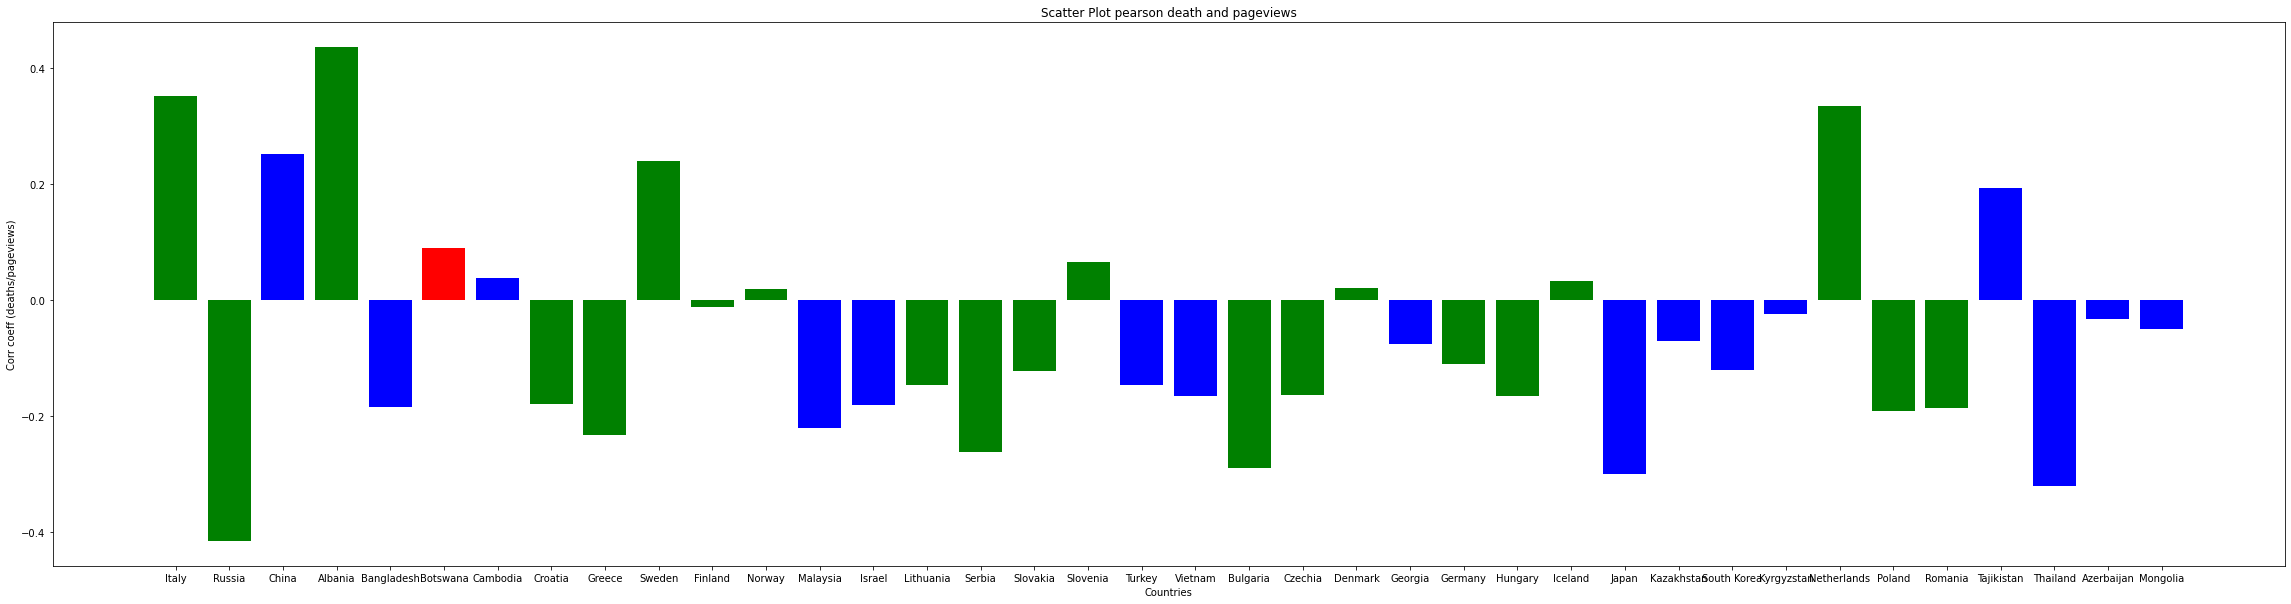

In [11]:
pearson_deathsT = pearson_deaths.transpose()
pearson_deathsT = pearson_deathsT.drop(index= 'Pearson correlation', axis=0)
pearson_deathsT = pearson_deathsT.rename(columns= {0: 'Correlation coefficient', 1: 'P-value'})
# create a new figure
plt.figure(figsize=(40, 10))

# use the scatter() function to plot the points,
# with red circles of size 10
colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Africa':'red'}
plt.bar(pearson_deathsT.index.values, pearson_deathsT['Correlation coefficient'].values, color=[colors[x] for x in country_to_continent(pearson_deathsT.index.values)])

# add a title
plt.title("Scatter Plot pearson death and pageviews")

# add x and y axis labels
plt.xlabel("Countries")
plt.ylabel("Corr coeff (deaths/pageviews)")

# show the plot
plt.show()